# Test notebook 
Test the model called by wandb. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from datetime import datetime
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from models.earlyrnn import EarlyRNN
from models.daily_earlyrnn import DailyEarlyRNN
import torch
from utils.losses.early_reward_loss import EarlyRewardLoss
from utils.losses.stopping_time_proximity_loss import StoppingTimeProximityLoss, sample_three_uniform_numbers
from utils.losses.daily_reward_loss import DailyRewardLoss
import pandas as pd
import pickle 
import wandb
import json
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_testing import test_dataset, get_test_stats
import matplotlib.pyplot as plt
from utils.plots_test import plot_doy_prob, plot_all_doy_probs, plot_confusion_matrix, plot_probability_stopping, \
    plot_fig_class_prob_wrt_time, plot_fig_class_prob_wrt_time_one_sample
from models.model_helpers import count_parameters

In [3]:
# config 
class Config():
    def __init__(self):
        self.alpha = 0.6
        self.backbonemodel = "LSTM"
        self.batchsize = 256
        self.corrected = True
        self.dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
        self.dataset = "breizhcrops"
        self.device = "cuda"
        self.epochs = 100
        self.epsilon = 10
        self.extra_padding_list = [0]
        self.hidden_dims = 64
        self.learning_rate = 0.001
        self.loss_weight = "balanced"
        self.patience = 30
        self.resume = False
        self.sequencelength = 365
        self.validation_set = "valid"
        self.weight_decay = 0
        self.daily_timestamps = True
        self.original_time_serie_lengths = [102]
        self.loss = "daily_reward"
        self.day_head_init_bias = 5
        self.decision_head = "day"
        self.start_decision_head_training = 0
        
args = Config()
print("cuda is available: ", args.device)
print(args)

cuda is available:  cuda


## Download the model from wandb 

In [4]:
api = wandb.Api()
entity, project, sweep = "aurenore", "MasterThesis", "x6ma4kpb"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list, sweep_list, start_date_list = [], [], [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    
    if run.sweep:
        sweep_list.append(run.sweep.name)
    else:
        sweep_list.append(None)
        
    start_date_list.append(run.createdAt)


runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list, "sweep": sweep_list, "start_date": start_date_list}
)
runs_df

,summary,config,name,sweep,start_date
0,"{'harmonic_mean': 0.35171058573677855, 'loss':...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",fallen-sweep-80,only_classification_first,2024-06-04T09:18:57
1,"{'fscore': 0.0008227396809457709, 'conf_mat_ta...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",icy-sweep-79,only_classification_first,2024-06-04T08:54:01
2,"{'earliness_reward': 2.322307586669922, 'accur...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",honest-sweep-78,only_classification_first,2024-06-04T08:42:13
3,"{'_timestamp': 1717492728.3409903, 'harmonic_m...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",scarlet-sweep-77,only_classification_first,2024-06-04T08:41:19
4,"{'_wandb': {'runtime': 2359}, 'recall': 0.7697...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",iconic-sweep-76,only_classification_first,2024-06-04T08:14:25
...,...,...,...,...,...
462,"{'precision': 0.5357233620913371, '_timestamp'...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",TempCNN-seqlength150,None,2024-03-28T15:16:29
463,"{'classification_loss': 6.784744739532471, 're...","{'alpha': 0.5, 'device': 'cpu', 'epochs': 100,...",LSTM-seqlength150,None,2024-03-28T15:15:39
464,"{'kappa': 0.6989531278523878, 'fscore': 0.5271...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",TempCNN-seqlength70,None,2024-03-28T13:54:08
465,"{'_timestamp': 1711570628.1319556, 'classifica...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",ELECTS-LSTM-hiddendims=32,None,2024-03-27T14:55:09


get the runs with certain sweep name, and created after a certain date

In [5]:
sweep_name = "only_classification_first"
# get the best run
df = runs_df[runs_df.sweep == sweep_name]
# get the runs that were created after the 1st of june 
# Convert the start_date column to datetime
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'])
# Filter rows where start_date is after 1st June 2024
df = df[df['start_date'] > datetime(2024, 6, 1)]
df

,summary,config,name,sweep,start_date
0,"{'harmonic_mean': 0.35171058573677855, 'loss':...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",fallen-sweep-80,only_classification_first,2024-06-04 09:18:57
1,"{'fscore': 0.0008227396809457709, 'conf_mat_ta...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",icy-sweep-79,only_classification_first,2024-06-04 08:54:01
2,"{'earliness_reward': 2.322307586669922, 'accur...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",honest-sweep-78,only_classification_first,2024-06-04 08:42:13
3,"{'_timestamp': 1717492728.3409903, 'harmonic_m...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",scarlet-sweep-77,only_classification_first,2024-06-04 08:41:19
4,"{'_wandb': {'runtime': 2359}, 'recall': 0.7697...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",iconic-sweep-76,only_classification_first,2024-06-04 08:14:25
...,...,...,...,...,...
75,"{'_wandb': {'runtime': 1876}, 'fscore': 0.7186...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",dutiful-sweep-11,only_classification_first,2024-06-03 13:53:34
76,"{'fscore': 0.7249028328325512, 'recall': 0.762...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",swept-sweep-10,only_classification_first,2024-06-03 13:37:50
77,"{'loss': {'testloss': 6.283744812011719, 'trai...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",faithful-sweep-12,only_classification_first,2024-06-03 13:01:49
78,"{'elects_earliness': 1, 'classification_loss':...","{'loss': 'daily_reward', 'alpha': 1, 'device':...",stellar-sweep-11,only_classification_first,2024-06-03 13:01:46


Here since we would like to see the best performance on the classification only, let's look at the fscore of the models and pick the best one.

In [6]:
# get the run with the highest fscore
chosen_run_idx = df.summary.apply(lambda x: x["fscore"]).idxmax()
chosen_run = runs[chosen_run_idx]
chosen_run_config = chosen_run.config
print("chosen run: ", chosen_run.name)
print("with fscore: ", chosen_run.summary._json_dict["fscore"])

chosen run:  pleasant-sweep-53
with fscore:  0.732036914475925


In [7]:
artifacts = chosen_run.logged_artifacts()
model = [artifact for artifact in artifacts if artifact.type == "model"][-1] # get the latest model artifact
model_path = model.download()
print(model_path)

# save config as json file
with open(os.path.join(model_path,"args.json"), "w") as f:
    json.dump(chosen_run_config, f)

wandb:   1 of 1 files downloaded.  


c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10


## Test.py - Test the model on the validation set 

In [8]:
# ----------------------------- LOAD DATASET -----------------------------
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    train_ds = BreizhCrops(root=dataroot,partition="train", sequencelength=args.sequencelength, corrected=args.corrected, \
        daily_timestamps=args.daily_timestamps, original_time_serie_lengths=args.original_time_serie_lengths)
    test_ds = BreizhCrops(root=dataroot,partition="valid", sequencelength=args.sequencelength, corrected=args.corrected, \
        daily_timestamps=args.daily_timestamps, original_time_serie_lengths=args.original_time_serie_lengths)
    nclasses = test_ds.nclasses
    class_names = test_ds.labels_names
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


2253658856 2253658856


loading data into RAM: 100%|██████████| 85310/85310 [00:34<00:00, 2476.35it/s]


2559635960 2559635960


loading data into RAM: 100%|██████████| 67523/67523 [00:28<00:00, 2404.48it/s]


class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


In [9]:
# print the difference between chosen_run_config and args
for key, value in chosen_run_config.items():
    if key not in args.__dict__:
        print(f"key {key} not in args, adding it with value {value}")
        args.__dict__[key] = value
    elif args.__dict__[key] != value:
        print(f"key {key} is different: {args.__dict__[key]} != {value}")
        # if the key is different, update it, unless it is the dataroot
        if key != "dataroot":
            print(f"adding the new value {value} to args")
            args.__dict__[key] = value

key alpha is different: 0.6 != 1
adding the new value 1 to args
key dataroot is different: C:\Users\anyam\elects_data != /home/amauron/elects/data/elects_data
key snapshot not in args, adding it with value /home/amauron/elects/data/elects_snapshots/model.pth
key alpha_decay not in args, adding it with value [1, 1]
key left_padding not in args, adding it with value False
key class_weights not in args, adding it with value [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
key nb_parameters not in args, adding it with value 66978
key day_head_init_bias is different: 5 != 1
adding the new value 1 to args
key start_decision_head_training is different: 0 != 40
adding the new value 40 to args


load the model and the criterion, and test the model on the validation set.

In [10]:
# ----------------------------- LOAD MODEL -----------------------------
if args.decision_head == "day":
        dict_model = {"start_decision_head_training": args.start_decision_head_training if hasattr(args, "start_decision_head_training") else 0,}
        model = DailyEarlyRNN(args.backbonemodel, nclasses=nclasses, input_dim=input_dim, sequencelength=args.sequencelength, hidden_dims=args.hidden_dims, day_head_init_bias=args.day_head_init_bias, **dict_model).to(args.device)
else:
    model = EarlyRNN(args.backbonemodel, nclasses=nclasses, input_dim=input_dim, sequencelength=args.sequencelength, hidden_dims=args.hidden_dims, left_padding=args.left_padding).to(args.device)

print("model is loading from: ", model_path)
model.load_state_dict(torch.load(os.path.join(model_path, "model.pth")))

# criterion
if args.loss_weight == "balanced":
    class_weights = torch.tensor(args.class_weights).to(args.device)
else: 
    class_weights = None

if args.loss == "early_reward":
    criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon, weight=class_weights)
elif args.loss == "stopping_time_proximity":
    alpha4 = 1-args.alpha1-args.alpha2-args.alpha3
    args.update({"alpha4": alpha4})
    criterion = StoppingTimeProximityLoss(alphas=[args.alpha1, args.alpha2, args.alpha3, args.alpha4], weight=class_weights)
elif args.loss == "daily_reward":
    criterion = DailyRewardLoss(alpha=args.alpha, weight=class_weights, alpha_decay=args.alpha_decay, epochs=args.epochs, start_decision_head_training=args.start_decision_head_training if hasattr(args, "start_decision_head_training") else 0)
else: 
    print(f"loss {args.loss} not recognized, loss set to default: early_reward")
    criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon, weight=class_weights)

print(f"The model has {count_parameters(model):,} trainable parameters.")



model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10
The model has 66,978 trainable parameters.


Extracting labels from dataset Validation.


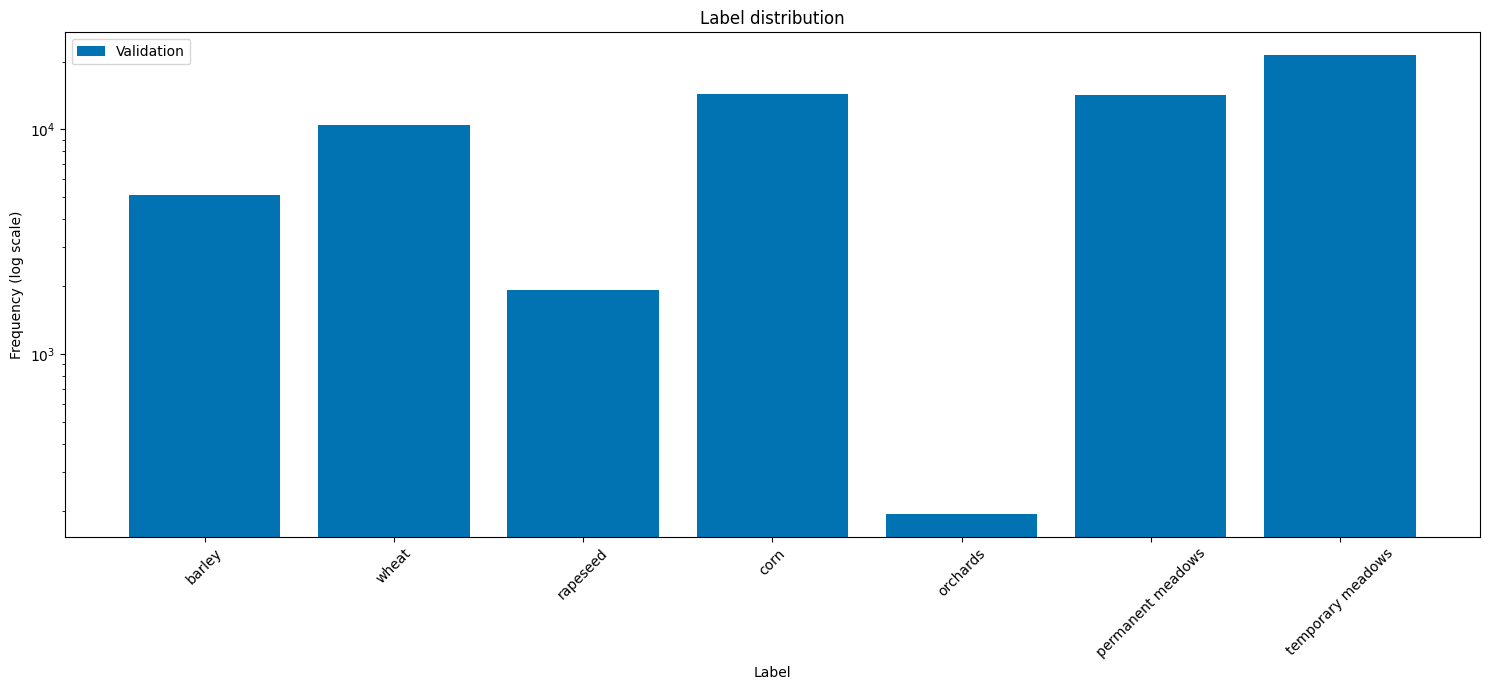

In [11]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Validation"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

## Test the model on the validation dataset

In [12]:
# ----------------------------- TEST -----------------------------
# if the files do not exist, they will be created
if os.path.exists(os.path.join(model_path, "testloss.pkl")) and os.path.exists(os.path.join(model_path, "stats.pkl")):
    print("testloss.pkl and stats.pkl exist. Loading them.")
    with open(os.path.join(model_path, "testloss.pkl"), "rb") as f:
        testloss = pickle.load(f)
    with open(os.path.join(model_path, "stats.pkl"), "rb") as f:
        stats = pickle.load(f)
else: 
    print("testloss.pkl or stats.pkl does not exist. Running test.")
    testloss, stats = test_dataset(model, test_ds, criterion, args.device, args.batchsize, extra_padding_list=args.extra_padding_list, \
        return_id=test_ds.return_id, daily_timestamps=args.daily_timestamps, kwargs={"epoch": 100, "criterion_alpha": args.alpha_decay[1]})

    # with open(os.path.join(model_path, "testloss.pkl"), "wb") as f:
    #     pickle.dump(testloss, f)
    # print("test loss saved to", os.path.join(model_path, "testloss.pkl"))

    # with open(os.path.join(model_path, "stats.pkl"), "wb") as f:
    #     pickle.dump(stats, f)
    # print("stats saved to", os.path.join(model_path, "stats.pkl"))
    
test_stats = get_test_stats(stats, testloss, args)

testloss.pkl or stats.pkl does not exist. Running test.


In [13]:
test_stats

{'test_loss': 7.2773643,
 'accuracy': 0.710306117915377,
 'precision': 0.7131107057179052,
 'recall': 0.7700324864424745,
 'fscore': 0.6956957641903866,
 'kappa': 0.6459576966708809,
 'elects_earliness': 0.0,
 'classification_loss': 7.2773643,
 'earliness_reward': 0.0,
 'harmonic_mean': 0.0}

## Graphs

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10\boxplot_stopping_times.png


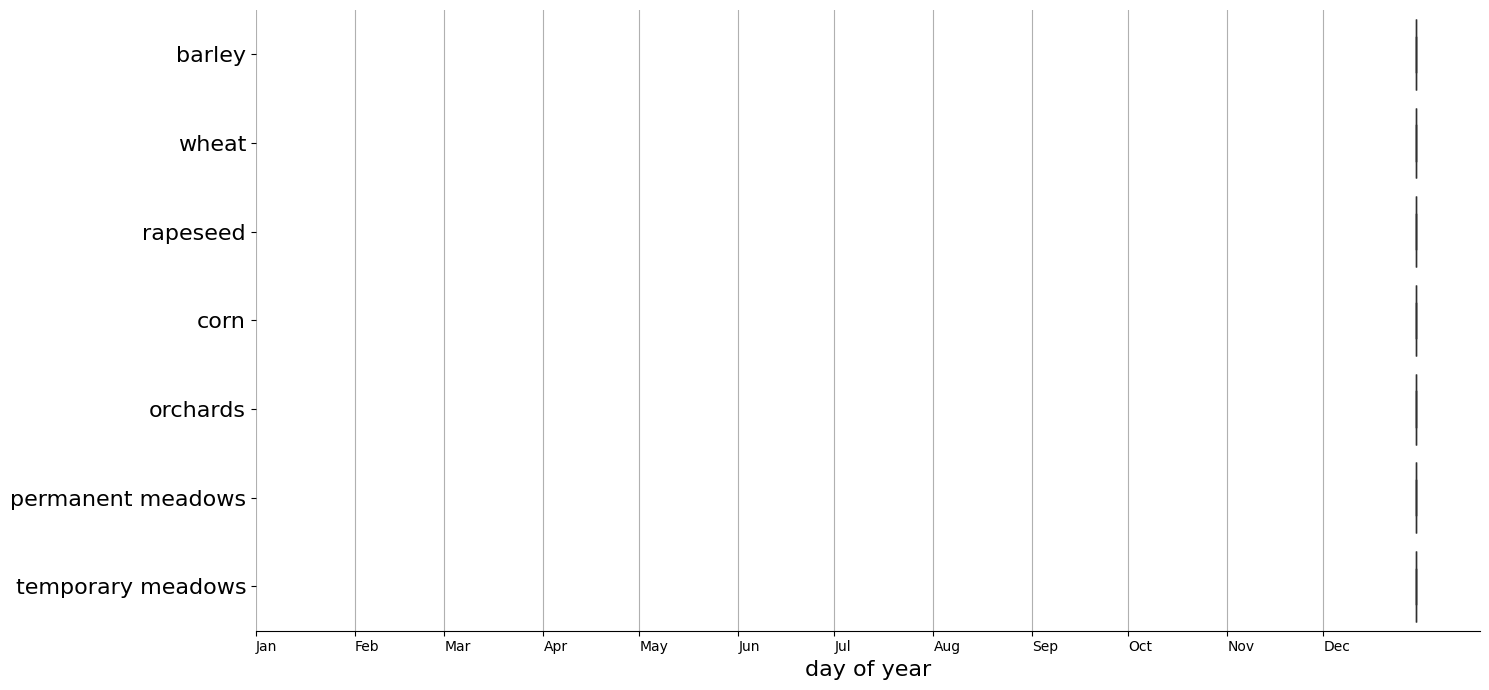

In [14]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict = get_approximated_doys_dict(stats["seqlengths"], length_sorted_doy_dict_test)
    doys_stop = get_doy_stop(stats, doys_dict)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)
                
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times.png"))
print("fig saved at ", os.path.join(model_path, "boxplot_stopping_times.png"))

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10\confusion_matrix.png


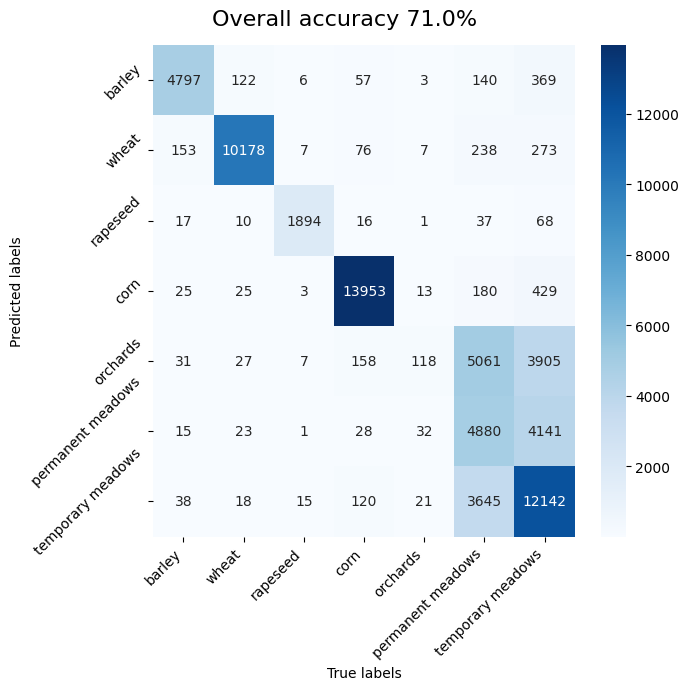

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_confusion_matrix(stats["targets"][:, 0], stats["predictions_at_t_stop"].flatten(), class_names, fig, ax)
fig.savefig(os.path.join(model_path, "confusion_matrix.png"))
print("fig saved at ", os.path.join(model_path, "confusion_matrix.png"))

Visualize the class probabilities through time for each class

figure saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10\class_probabilities_through_time.png


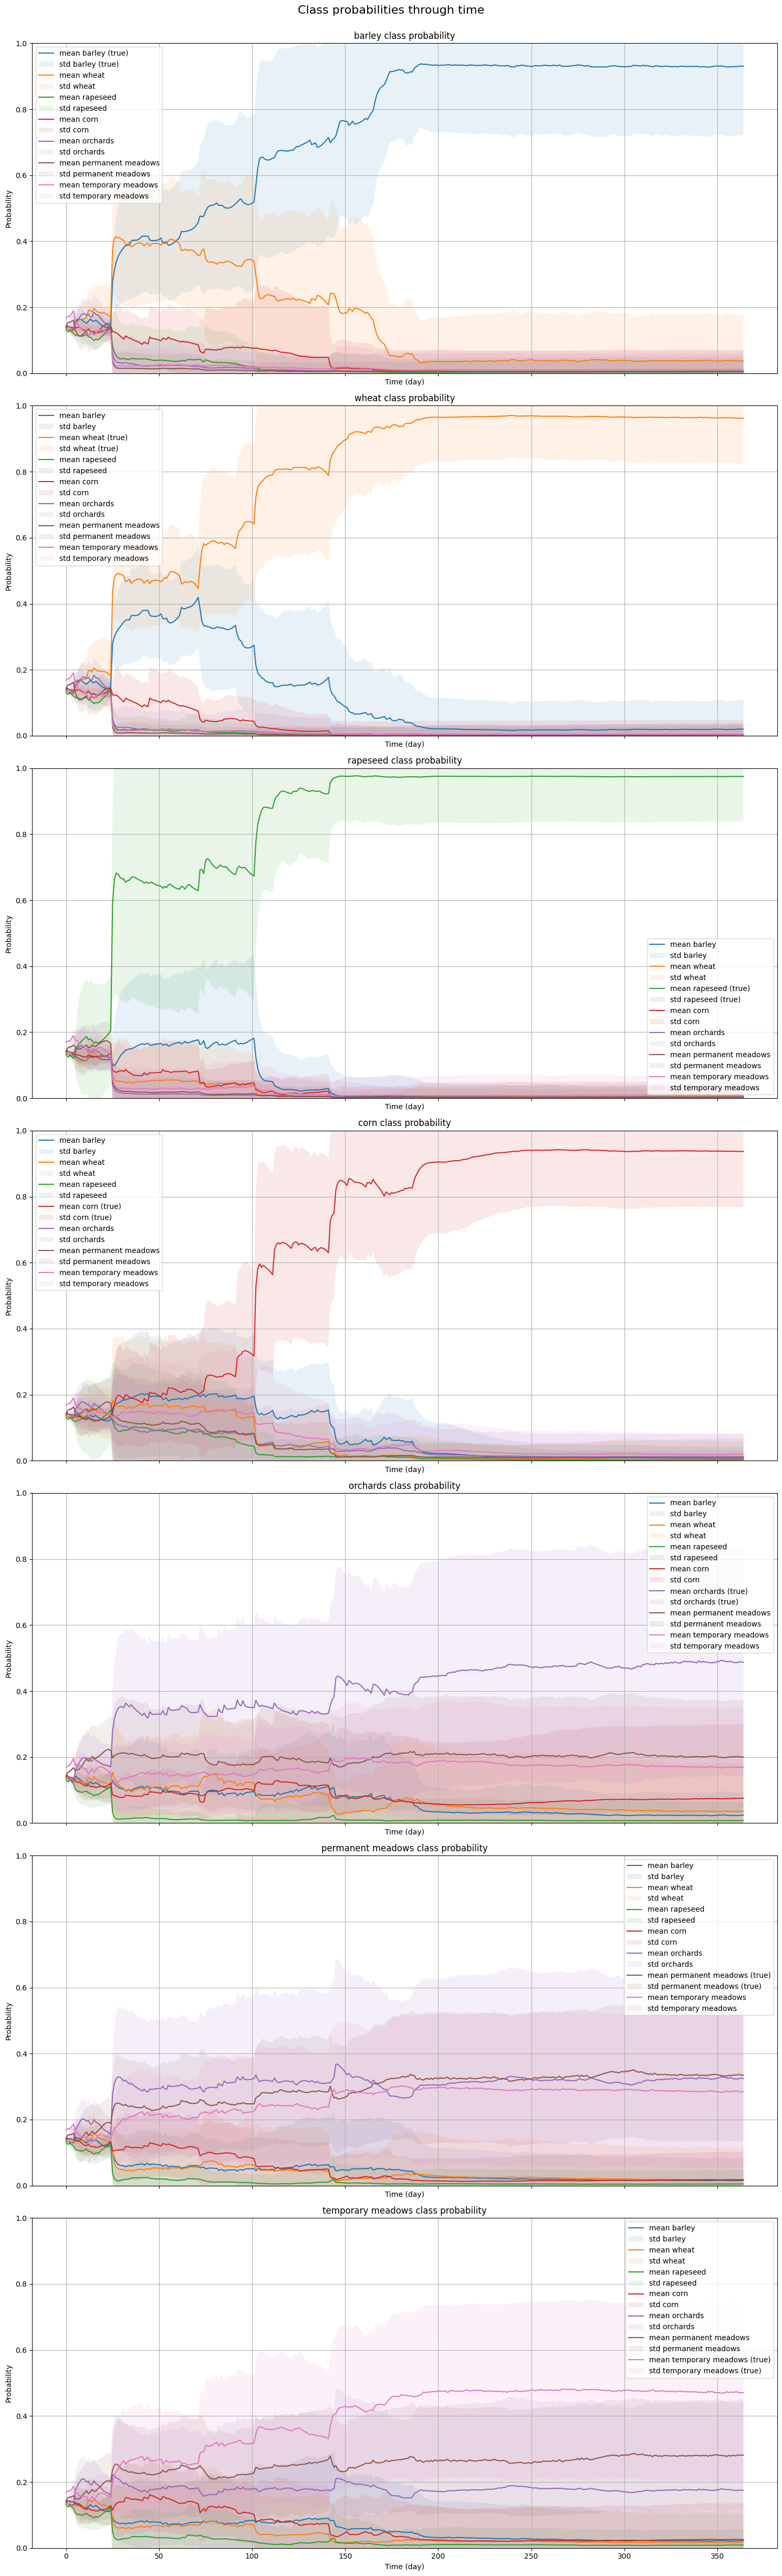

In [16]:
class_prob = stats["class_probabilities"]
y_true = stats["targets"][:, 0]

fig, axes = plt.subplots(figsize=(15, 7*len(class_names)), nrows=len(class_names), sharex=True)
fig, axes = plot_fig_class_prob_wrt_time(fig, axes, class_prob, y_true, class_names, alpha=0.1)
fig.savefig(os.path.join(model_path, "class_probabilities_through_time.png"))
print("figure saved at ", os.path.join(model_path, "class_probabilities_through_time.png"))

One sample per class, and the class probabilities through time

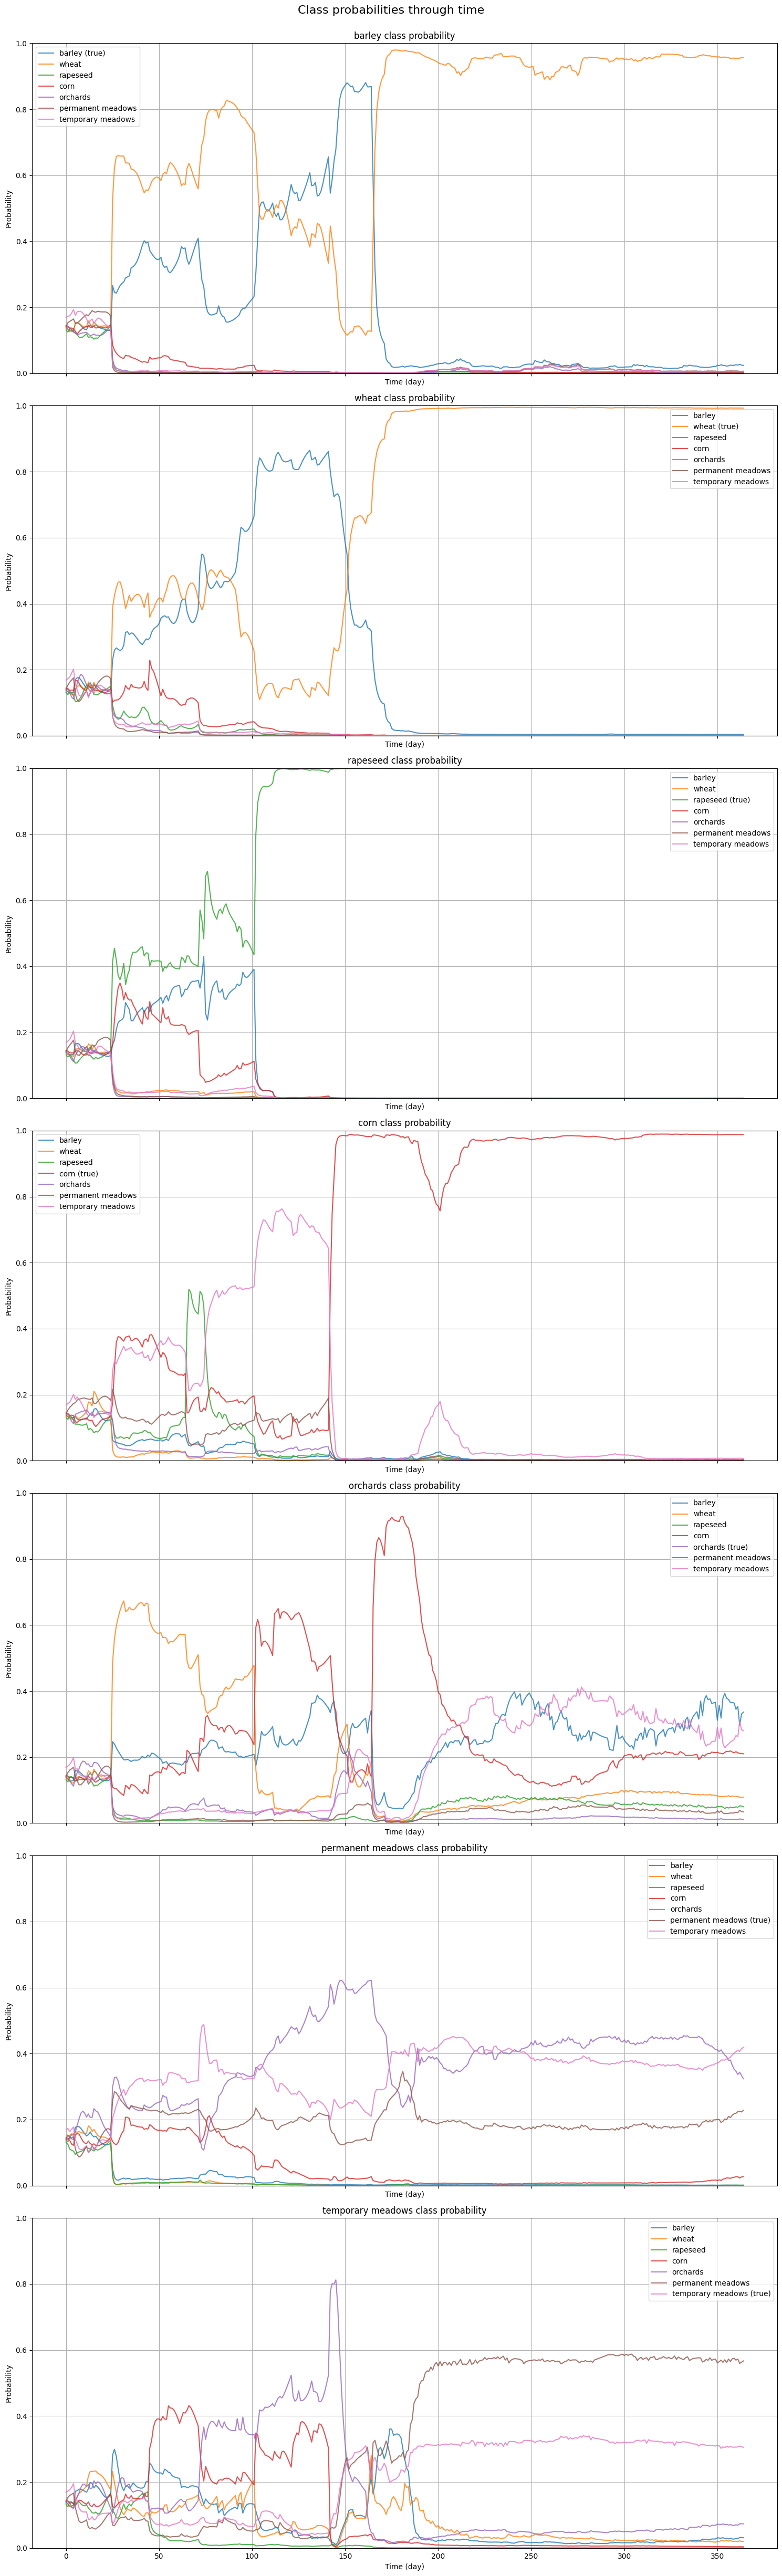

In [18]:
class_prob = stats["class_probabilities"]
y_true = stats["targets"][:, 0]
fig, axes = plt.subplots(figsize=(15, 7*len(class_names)), nrows=len(class_names), sharex=True)
fig, axes = plot_fig_class_prob_wrt_time_one_sample(fig, axes, class_prob, y_true, class_names, alpha=0.8)
# fig.savefig(os.path.join(model_path, "class_probabilities_through_time.png"))
# print("figure saved at ", os.path.join(model_path, "class_probabilities_through_time.png"))